## Sept 29, 2021 Example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from herbie import Herbie
from datetime import datetime, timedelta

# ==== USER INPUT ====
DATE = "2021-08-31 00:00"      # Set initialization time to September 28, 2023
LAT_LON = (40.7128, -74.0060)  # Chosen latitude and longitude (e.g., NYC, NY)
# =====================

import warnings

warnings.filterwarnings( # silence xarray timedelta warning
    "ignore",
    message=".*decode_timedelta will default to False.*",
    category=FutureWarning,
    module="cfgrib.xarray_plugin"
)

# GEFS ensemble members
GEFS_MEMBERS = [f"p{str(i).zfill(2)}" for i in range(1, 31)] + ["c00"]

def get_gefs_precip(init_time, forecast_hours, members):
    """Download GEFS APCP from atmos.5 product for each member at each forecast hour."""
    precip_data = {fxx: [] for fxx in forecast_hours}

    for member in members:
        print('members', member)
        for fxx in forecast_hours:
            try:
                H = Herbie(init_time, model="gefs", product="atmos.5", member=member, fxx=fxx)
                ds = H.xarray("APCP:surface")
                precip_data[fxx].append(ds)  # Keep the whole dataset, not just tp values
            except Exception as e:
                print(f"Skipping member {member}, forecast hour {fxx}: {e}")

    return precip_data

# ==== MAIN ====
init_dt = datetime.strptime(DATE, "%Y-%m-%d %H:%M")

# Define forecast hours: From F000 to F072 (covering 3 days, 72 hours), every 3 hours (0, 3, 6, ..., 72)
forecast_hours = list(range(3, 73, 3))  # 72 hours (3-day forecast) at 3-hour intervals

# Fetch APCP data for every forecast hour
precip_data = get_gefs_precip(init_dt, forecast_hours, GEFS_MEMBERS)

members p01
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Aug-31 00:00 UTC F03 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Aug-31 00:00 UTC F06 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Aug-31 00:00 UTC F09 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Aug-31 00:00 UTC F12 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Aug-31 00:00 UTC F15 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Aug-31 00:00 UTC F18 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Aug-31 00:00 UTC F21 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Aug-31 00:00 UTC F24 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Aug-31 00:00 UTC F27 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Aug-31 00:00 UTC F30 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2021-Aug-31 00:00

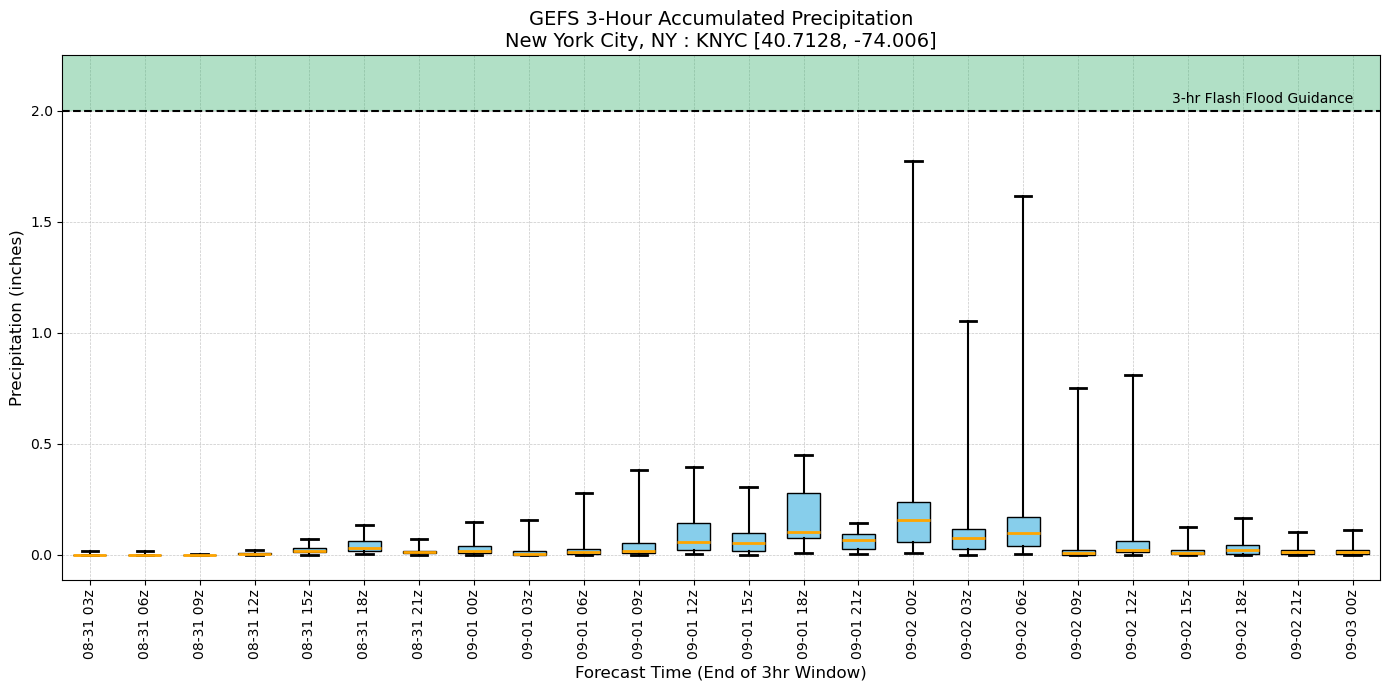

In [7]:
def extract_precip_at_lat_lon(ds, lat, lon):
    """Extract precipitation at a specific latitude and longitude."""
    return ds.sel(latitude=lat, longitude=lon, method='nearest')["tp"].values.item()

def plot_boxplots_across_time(precip_data, forecast_hours, init_time):
    fig, ax = plt.subplots(figsize=(14, 7))

    # Prepare data for box plots across forecast hours
    box_data = []
    valid_forecast_hours = []
    forecast_times = []

    for fxx in forecast_hours:
        # Extract precip for each member at the specified lat/lon
        flattened_data = [extract_precip_at_lat_lon(ds, LAT_LON[0], LAT_LON[1]) for ds in precip_data[fxx]]
        if flattened_data:  # Only include forecast hours with data
            in_values = [(mm/25.4) for mm in flattened_data] # convert from mm to in
            box_data.append(in_values)
            valid_forecast_hours.append(fxx)
            # Calculate the actual time for the forecast hour
            forecast_time = init_time + timedelta(hours=fxx)
            forecast_times.append(forecast_time)

    if not box_data:
        print("No data available to plot.")
        return

    # Box plot for each forecast hour (no outliers, whiskers extend to min and max values)
    bp = ax.boxplot(box_data, positions=np.arange(len(valid_forecast_hours)), widths=0.6, patch_artist=True,
                    boxprops=dict(facecolor="skyblue", color="black"),
                    whiskerprops=dict(color="black", linewidth=1.5),
                    flierprops=dict(markerfacecolor='red', marker='o', markersize=7),
                    capprops=dict(color="black", linewidth=2),
                    medianprops=dict(color="orange", linewidth=2),
                    autorange=True, whis=np.inf)  # Set whiskers to extend to min and max

    # Add 2-inch threshold line and shading up to 2.5 inches
    ax.axhline(2.0, color='black', linestyle='--', linewidth=1.5, label='2-inch threshold')
    ax.axhspan(2.0, 2.25, facecolor='mediumseagreen', alpha=0.4, label='2–2.5 inch range')

    # Annotate the 2-inch line
    ax.text(0.98, 2.02, "3-hr Flash Flood Guidance", ha='right', va='bottom',
        transform=ax.get_yaxis_transform(), fontsize=10, color='black')

    # Set labels and title
    ax.set_xticklabels([forecast_time.strftime("%m-%d %Hz") for forecast_time in forecast_times], rotation=90, fontsize=10)
    ax.set_xlabel("Forecast Time (End of 3hr Window)", fontsize=12)
    ax.set_ylabel("Precipitation (inches)", fontsize=12)
    ax.set_title(f"GEFS 3-Hour Accumulated Precipitation\nNew York City, NY : KNYC [{LAT_LON[0]}, {LAT_LON[1]}]", fontsize=14)
    
    # Customize grid and layout
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.set_axisbelow(True)  # Ensure grid is below plot elements

    ax.set_ylim(top=2.25)
    
    plt.tight_layout()
    plt.show()

# Plot box plots for each forecast hour at the chosen lat/lon
plot_boxplots_across_time(precip_data, forecast_hours, init_dt)

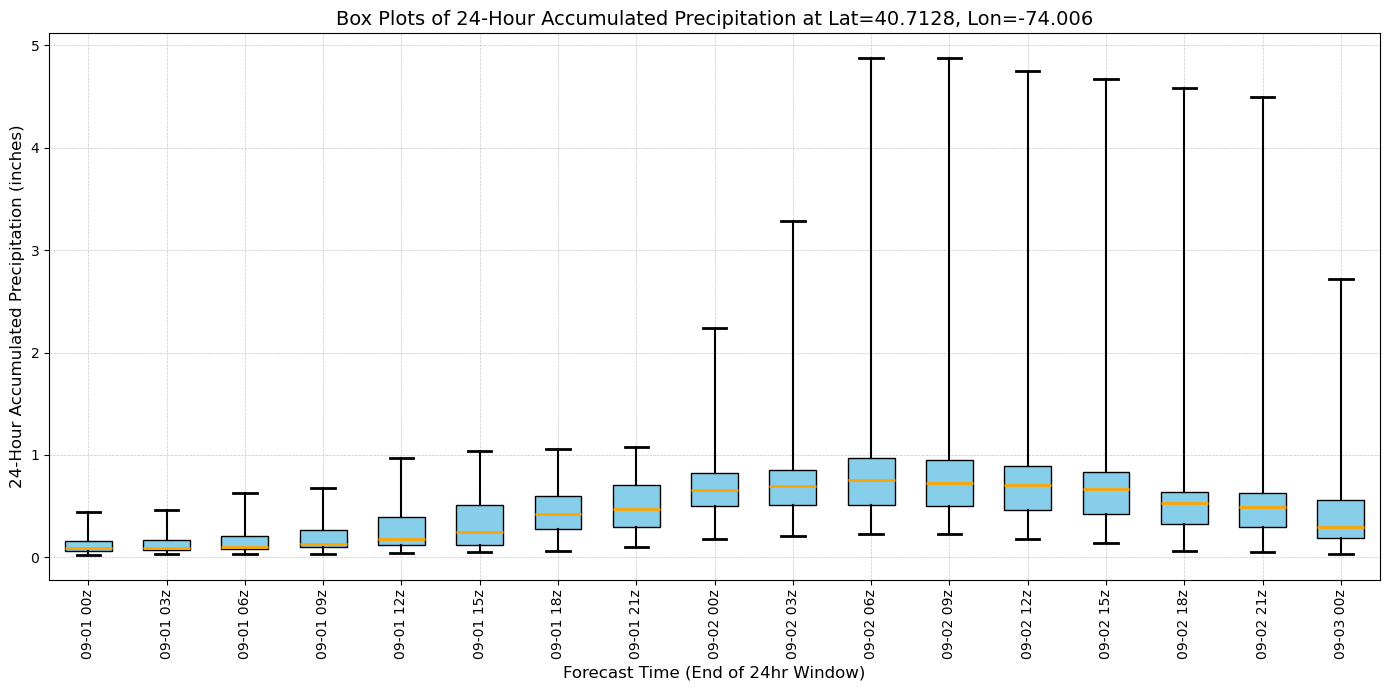

In [10]:
def plot_24hr_boxplots_across_time(precip_data, forecast_hours, init_time):
    fig, ax = plt.subplots(figsize=(14, 7))

    box_data = []
    valid_forecast_hours = []
    forecast_times = []

    for i in range(0, len(forecast_hours) - 7):
        block_hours = forecast_hours[i:i + 8]  # 8 x 3hr = 24hr window

        # Ensure all 8 forecast hours are in the data
        if not all(fxx in precip_data for fxx in block_hours):
            continue

        # Determine min number of members across all 8 time steps
        min_members = min(len(precip_data[fxx]) for fxx in block_hours)
        if min_members == 0:
            continue  # Skip if any block has no members

        # Sum 3hr precip over 24hr window for each member
        summed_precip = []
        for member_idx in range(min_members):
            total_precip = 0.0
            for fxx in block_hours:
                try:
                    precip = extract_precip_at_lat_lon(precip_data[fxx][member_idx], LAT_LON[0], LAT_LON[1])
                    total_precip += precip
                except IndexError:
                    # Skip member if any data is missing
                    total_precip = None
                    break
            if total_precip is not None:
                summed_precip.append(total_precip / 25.4)  # mm to in

        if summed_precip:
            box_data.append(summed_precip)
            valid_forecast_hours.append(block_hours[-1])
            forecast_times.append(init_time + timedelta(hours=block_hours[-1]))

    if not box_data:
        print("No data available to plot.")
        return

    bp = ax.boxplot(box_data, positions=np.arange(len(valid_forecast_hours)), widths=0.6, patch_artist=True,
                    boxprops=dict(facecolor="skyblue", color="black"),
                    whiskerprops=dict(color="black", linewidth=1.5),
                    flierprops=dict(markerfacecolor='red', marker='o', markersize=7),
                    capprops=dict(color="black", linewidth=2),
                    medianprops=dict(color="orange", linewidth=2),
                    autorange=True, whis=np.inf)

    ax.set_xticklabels([forecast_time.strftime("%m-%d %Hz") for forecast_time in forecast_times], rotation=90, fontsize=10)
    ax.set_xlabel("Forecast Time (End of 24hr Window)", fontsize=12)
    ax.set_ylabel("24-Hour Accumulated Precipitation (inches)", fontsize=12)
    ax.set_title(f"Box Plots of 24-Hour Accumulated Precipitation at Lat={LAT_LON[0]}, Lon={LAT_LON[1]}", fontsize=14)
    
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax.set_axisbelow(True)

    plt.tight_layout()
    plt.show()

# Plot box plots for each forecast hour at the chosen lat/lon
plot_24hr_boxplots_across_time(precip_data, forecast_hours, init_dt)